# Librerias

In [3]:
# from oficial python
import numpy as np
import matplotlib.pyplot as plt
from qutip import Bloch
from matplotlib import cm
import matplotlib as mpl
from qutip import basis, tensor
import time
from sklearn.model_selection import train_test_split
import pennylane as qml
import os
import pandas as pd

# own modules:
from dll.spin_procesor_modificated import Quantum_Spin_Proces
from dll.main_fun import make_IRIS_v2, pulse_x_with_noise, pulse_x, pulse_z
from dll. baseline_dru_v2 import Modelo_DRU
from dll.models import qcircuit_1_qubit_mixed, qcircuit_2_qubit_mixed, qcircuit_4_qubit_mixed
from dll.cost_functions import fidelity_cost
from dll.gate_procesor_modificated import CompositeGateProcessor

# Funciones

In [4]:
def calculate_fidelity(state_base_line, state_spins):
  # convert spin to dm
  nf, nc = state_spins.shape
  if nc == 1:
    dm_spin = state_spins @ state_spins.conj().T
  # calculare fidelity:
  F  = qml.math.fidelity(state_base_line, dm_spin)
  return F

In [5]:
def make_total_pulse(B0_pulses):
  # Convertir el array a tipo float para poder asignar NaN
  B0_pulses = B0_pulses.astype(float)

  # Crear un vector complementario donde los ceros se reemplazan por unos
  B0_complement = np.where(B0_pulses == 0, np.min(B0_pulses), B0_pulses)

  # Crear una máscara para los valores que son cero en el vector original
  mask = B0_pulses == 0

  # Crear una copia del vector original para graficar los valores reales mayores que cero
  B0_pulses_real = np.copy(B0_pulses)
  B0_pulses_real[mask] = np.nan  # Reemplazar los ceros con NaN para no plotearlos

  # Crear una copia del vector complementario para graficar los valores complementados
  B0_pulses_complement = np.copy(B0_complement)
  B0_pulses_complement[~mask] = np.nan  # Reemplazar los valores no complementados con NaN
  
  return B0_complement, B0_pulses_complement

# Correr modelo 2 qubits con entrelazamiento

In [6]:
# 2 qubits con entrelazamiento:
X, y =  make_IRIS_v2(3,3)

tf_entanglement = True

model = Modelo_DRU(qcircuit_2_qubit_mixed, fidelity_cost,
                        epochs = 2, n_clases = 3, n_qubits = 2,
                        features = 3, num_layers = 4, alpha_noise = 0.0, val_prc = 0.2,
                        save_process = False, save_w_states = True,
                        entanglement = tf_entanglement )

# splita data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# get optimized parameters
paramters_1q, bias_1q = model.fit(X_train, y_train, X_test, y_test)

dru_circuit = CompositeGateProcessor(n_points_pulse_Ri=1000,
                                     N_qubits = 2,
                                     tf_noise = False,
                                     noise_std = 0.0000,
                                     ket_dru_0 = tensor(basis(2, 0),basis(2, 0)),
                                     save_pulses= True,
                                     J = 1.52e11)

state_dru = dru_circuit.qcircuit_DRU_2_Qubit(paramters_1q,
                                             model.X_val[1],
                                             bias=bias_1q,
                                             entanglement = tf_entanglement)

Epoch: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


# Graficar Pulsos

In [97]:
# Tomar todos los pulsos:
resultado = dru_circuit.pulse_type
# resultado[0] # Acá seleccionamos el qubit:

In [98]:
# Definir el tiempo global de simulación:
glob_time = dru_circuit.global_time
glob_time

8.233318236834186e-08

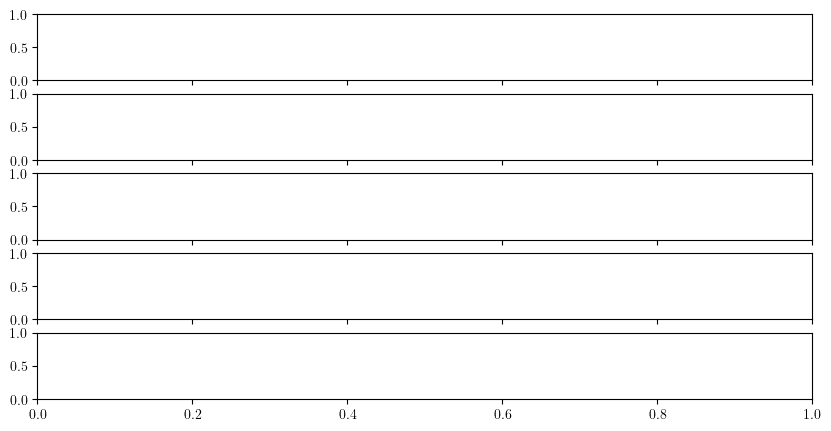

In [87]:
num_plots = 5  # Limitar a 5 gráficos
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5), sharex=True)

In [99]:
fontsize_axes=11
fontsize_title=11
fontsize_text=11
fontsize_ticks=8
fontsize_legend=8

In [100]:
labelpad_value = 20

C:\Users\User\AppData\Local\Temp\ipykernel_12356\552609441.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[idx_global].plot(global_time_sim * 1e9, B0_pulses_blue, 'b-', label=r'Real $B_z$', color='darkblue')
C:\Users\User\AppData\Local\Temp\ipykernel_12356\552609441.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[idx_global].plot(global_time_sim * 1e9, B1_pulses, 'b-', label=r'Real $B_x$', color='darkblue')


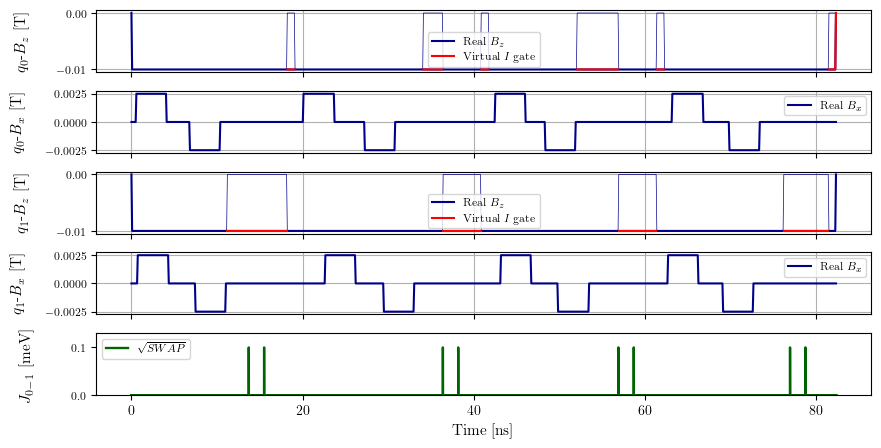

In [104]:
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5), sharex=True)
idx_global = 0
for idx, key in enumerate(resultado):
  
    list_pulses = resultado[key]  # c/u qubit.
    
    if list_pulses[0]['Type_pulse'] == 'Unitary':
      
        global_time_sim = np.linspace(0, glob_time, 1000)  # Tiempo total de simulación
        B1_pulses = np.zeros(len(global_time_sim))  # Vector para guardar pulso Bx
        B0_pulses = np.zeros(len(global_time_sim))  # Vector para guardar pulso B0
        
        for dict_pulse in list_pulses:
            # B0 results
            args2 = {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
            B0_i = dict_pulse['B0'] * pulse_z(global_time_sim, args2)
            B0_pulses += np.array(B0_i)
            
            # B1 results
            dv = dru_circuit.noise_std / abs(dict_pulse['B1']) if dict_pulse['B1'] != 0 else 0
            args2 = {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f'], "std_noise": dv}
            B1_i = dict_pulse['B1'] * pulse_x_with_noise(global_time_sim, args2)
            B1_pulses += np.array(B1_i)
        
        B0_pulses_blue, B0_pulses_red = make_total_pulse(B0_pulses)
        B0_pulses_blue[0] = B0_pulses_blue[-1] = 0
        B0_pulses_red[0] = B0_pulses_red[-1] = 0
        
        # Graficar el pulso B0
        axes[idx_global].plot(global_time_sim * 1e9, B0_pulses, linewidth=0.5, color='darkblue')
        axes[idx_global].plot(global_time_sim * 1e9, B0_pulses_blue, 'b-', label=r'Real $B_z$', color='darkblue')
        axes[idx_global].plot(global_time_sim * 1e9, B0_pulses_red, 'r-', label=r'Virtual $I$ gate')
        axes[idx_global].set_ylabel(f"$q_{key}$-$B_z$ [T]", fontsize=fontsize_axes, labelpad=labelpad_value)  # Reduce tamaño del texto
        axes[idx_global].tick_params(axis='y', labelsize=fontsize_ticks)  # Reduce tamaño de ticks
        axes[idx_global].grid()
        axes[idx_global].legend(fontsize=fontsize_legend)  # Reduce tamaño de la leyenda
        
        idx_global += 1
        
        # Graficar el pulso B1
        axes[idx_global].plot(global_time_sim * 1e9, B1_pulses, 'b-', label=r'Real $B_x$', color='darkblue')
        axes[idx_global].set_ylabel(f"$q_{key}$-$B_x$ [T]", fontsize=fontsize_axes, labelpad=labelpad_value-6)
        axes[idx_global].tick_params(axis='y', labelsize=fontsize_ticks)
        axes[idx_global].grid()
        axes[idx_global].legend(fontsize=fontsize_legend)  # Reduce tamaño de la leyenda
        
        idx_global += 1
        
    
    elif list_pulses[0]['Type_pulse'] == "Two_Qubits":
      
        global_time_sim = np.linspace(0, glob_time, 10000)
        swap_color = 'darkblue'
        sqrt_swap_color = 'darkgreen'
        swap_plotted = False
        sqrt_swap_plotted = False
        
        for dict_pulse in list_pulses:
          
            J_pulses = np.zeros(len(global_time_sim))
            t_i = dict_pulse['t_i']
            t_f = dict_pulse['t_f']
            J = dict_pulse['J']
            args2 = {"t_init": dict_pulse['t_i'], "t_final": dict_pulse['t_f']}
            hbar = 6.582e-13
            J_i = hbar * dict_pulse['J'] * pulse_x(global_time_sim, args2)
            J_pulses += np.array(J_i)
            t_center = (t_f + t_i) / 2
            y_text = hbar * dict_pulse['J'] * 1.05
            label = "SWAP" if abs((t_f - t_i) - np.pi / J) < 1e-13 else r"$\sqrt{SWAP}$"
            color = swap_color if label == "SWAP" else sqrt_swap_color if label == r"$\sqrt{SWAP}$" else 'gray'
            
            if label == "SWAP" and not swap_plotted:
                axes[idx_global].plot(global_time_sim * 1e9, J_pulses, linewidth=1.7, color=color, label='SWAP')
                swap_plotted = True
            elif label == r"$\sqrt{SWAP}$" and not sqrt_swap_plotted:
                axes[idx_global].plot(global_time_sim * 1e9, J_pulses, linewidth=1.7, color=color, label=r'$\sqrt{SWAP}$')
                sqrt_swap_plotted = True
            else:
                axes[idx_global].plot(global_time_sim * 1e9, J_pulses, linewidth=1.7, color=color)
                
        axes[idx_global].set_ylim([0, (np.max(J_pulses)) * 1.30])
        axes[idx_global].set_ylabel("$J_{0-1}$ [meV]", fontsize=fontsize_axes, labelpad=labelpad_value+7)
        axes[idx_global].set_xlabel("Time [ns]", fontsize=fontsize_axes)
        axes[idx_global].tick_params(axis='y', labelsize=fontsize_ticks)
        axes[idx_global].grid()
        axes[idx_global].legend(fontsize=fontsize_legend)  # Reduce tamaño de la leyenda

# Ajustes generales para reducir el espacio
plt.subplots_adjust(hspace=0.3)  # Ajusta el espacio vertical entre gráficos
plt.gcf().set_size_inches(10, 5)  # Cambia el tamaño total de la figura

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.grid()
path_to_save_img = os.path.join("results_of_test", "test_3",
                                f"J.pdf")
plt.savefig(path_to_save_img, format='pdf', bbox_inches='tight')
plt.show()


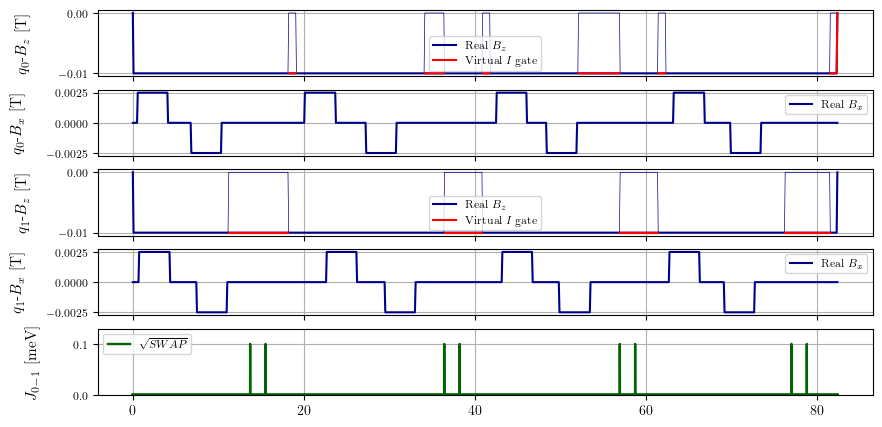

In [91]:
fig